##IMPLEMENTATION OF CNN MODEL WITH RESIDUAL CONNECTION(S)

In [ ]:
#import necessary modules
import os
import random
import shutil
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR



###PUBLIC VARIABLES

In [ ]:
#number of images that will be used from each class
num_images_per_class = 70
#number of train images that will be used from each class
num_train_per_class = 50
#number of validation images that will be used from each class
num_val_per_class = 10

img_size = 64
batch_size = 8
num_classes = 8
learning_rate = 0.0001
num_epoch = 30

###Load Data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#the dataset path in  Google Drive
root_dir = "/content/drive/MyDrive/Micro_Organism"

Mounted at /content/drive


In [ ]:
#create directories for train, validation, test data
os.makedirs("train")
os.makedirs("validation")
os.makedirs("test")

In [ ]:
# Get the sorted list of classes (subdirectories) in the root directory
classes = sorted(os.listdir(root_dir))
# Iterate over each class
for dir_name in classes:
    #get path to images
    images_dir = os.path.join(root_dir, dir_name)
    #get images names
    filenames = os.listdir(images_dir)
    random.seed(42)
    #shuffle images
    random.shuffle(filenames)

    # Create paths for train, validation, and test sets
    train_path = os.path.join('train', dir_name)
    val_path = os.path.join('validation', dir_name)
    test_path = os.path.join('test', dir_name)

    if not os.path.exists(train_path):
        os.makedirs(train_path)
        os.makedirs(val_path)
        os.makedirs(test_path)

    # Copy images to the respective train, validation, and test directories
    for i in range(num_images_per_class):
        filename = filenames[i]
        filepath = os.path.join(images_dir, filename)
        if (i < num_train_per_class):
          shutil.copy(filepath, train_path)
        elif ( i < num_train_per_class + num_val_per_class):
          shutil.copy(filepath, val_path)
        else:
          shutil.copy(filepath, test_path)



In [ ]:
# Define  transformations to be applied to the images
all_transforms = transforms.Compose([transforms.Resize((img_size ,img_size )),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])

# Create the train,validation,test set with the given transformations
trainset = datasets.ImageFolder(root="train", transform=all_transforms)
valset = datasets.ImageFolder(root="validation", transform=all_transforms)
testset = datasets.ImageFolder(root="test", transform=all_transforms)

In [ ]:
# Create data loaders for the train, validation, and test sets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validationloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

###CNN Model


In [ ]:
import torch.nn.functional as F
class CnnModel(nn.Module):
    def __init__(self,num_classes):
        super( CnnModel, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))    #output 16 x 32 x 32

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())                                    #output 32 x 32 x 32

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())                                    #output 64 x 32 x 32

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())                                    #output 64 x 32 x 32

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())                                   #output 128 x 32 x 32

        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())                                  #output 128 x 32 x 32

        self.fc = nn.Sequential(
           #nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(128* (img_size // 2 ) * (img_size//2),  num_classes))


    def forward(self, x):
        out = self.layer1(x)

        out = self.layer2(out)
        out = self.layer3(out)
        residual = out
        out = self.layer4(out)
        out = out + residual
        out = self.layer5(out)
        out = self.layer6(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = F.log_softmax(out, dim=1)
        return out





###TRAIN & VALIDATE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def train_one_epoch(model):
  running_loss = 0.
  running_acc = 0
  last_loss = 0
  last_acc = 0
  for i, data in enumerate(trainloader):
    # Every data instance is an input + label pair
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    # Zero your gradients for every batch!
    optimizer.zero_grad()
    # Make predictions for this batch
    outputs = model(inputs)

    # Compute the loss and its gradients
    loss = criterion(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    loss.backward()
    # Adjust learning weights
    optimizer.step()
    # Gather data and report
    running_loss += loss.item()
    acc =  ((predicted == labels).sum().item() / num_classes) * 100
    running_acc += acc
    if i % batch_size ==  batch_size-1:
      last_loss = running_loss / batch_size  # loss per batch
      last_acc = (running_acc / batch_size) # acc per batch
      print('batch {} loss: {} acc: {} % '.format(i + 1, last_loss, last_acc))
      running_loss = 0.
      running_acc = 0.

  return last_loss, last_acc

def train_val(model):
        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []
        best_models = []
        best_models_path = []
        best_vacc= 0
        model.to(device)
        for epoch in range(num_epoch):
            print("EPOCH:  " ,epoch)
            model.train(True)
            avg_loss , avg_acc = train_one_epoch(model)

            running_vloss = 0.0
            running_vacc = 0.0
            model.eval()


            # Disable gradient computation and reduce memory consumption.
            with torch.no_grad():
                for i, vdata in enumerate(validationloader):
                    vinputs, vlabels = vdata
                    vinputs = vinputs.to(device)
                    vlabels = vlabels.to(device)
                    voutputs = model(vinputs)
                    vloss = criterion(voutputs, vlabels)
                    running_vloss += vloss.item()

                    _, vpredicted = torch.max(voutputs.data, 1)
                    vacc =  ((vpredicted == vlabels).sum().item() / num_classes) * 100
                    running_vloss += vloss.item()
                    running_vacc += vacc


            avg_vloss = running_vloss / (i + 1)
            avg_vacc = running_vacc / (i + 1)

            train_loss.append(avg_loss)
            train_acc.append(avg_acc)
            val_loss.append(avg_vloss)
            val_acc.append(avg_vacc)
            print('LOSS train {:.3f} valid {}'.format(avg_loss, avg_vloss))
            print("avg loss " , avg_vloss)
            if avg_vacc > best_vacc:
                best_vacc = avg_vacc
                #model_path = 'model_{:.3f}_{}'.format(best_vloss, epoch)
                best_models.append(model)
                #best_models_path.append(model_path)

        #torch.save(best_models[-1].state_dict(), best_models_path[-1])
        return train_loss, train_acc, val_loss , val_acc , best_models[-1]


In [ ]:
model = CnnModel(8).to(device) # move model to GPU
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


train_loss, train_acc, val_loss, val_acc, best_model = train_val(model)

EPOCH:   0
batch 8 loss: 2.3038615584373474 acc: 14.0625 % 
batch 16 loss: 2.575757771730423 acc: 17.1875 % 
batch 24 loss: 2.947880834341049 acc: 15.625 % 
batch 32 loss: 2.7321989089250565 acc: 17.1875 % 
batch 40 loss: 3.2780089378356934 acc: 14.0625 % 
batch 48 loss: 2.6652838736772537 acc: 25.0 % 
LOSS train 2.665 valid 5.656743001937866
avg loss  5.656743001937866
EPOCH:   1
batch 8 loss: 0.8575250990688801 acc: 65.625 % 
batch 16 loss: 0.9788523279130459 acc: 67.1875 % 
batch 24 loss: 0.7634823322296143 acc: 76.5625 % 
batch 32 loss: 0.8724202588200569 acc: 70.3125 % 
batch 40 loss: 0.8687968403100967 acc: 71.875 % 
batch 48 loss: 0.6474029831588268 acc: 79.6875 % 
LOSS train 0.647 valid 4.775958478450775
avg loss  4.775958478450775
EPOCH:   2
batch 8 loss: 0.3051758408546448 acc: 90.625 % 
batch 16 loss: 0.36309485137462616 acc: 90.625 % 
batch 24 loss: 0.36425011418759823 acc: 95.3125 % 
batch 32 loss: 0.3624568711966276 acc: 93.75 % 
batch 40 loss: 0.31284185592085123 acc: 93

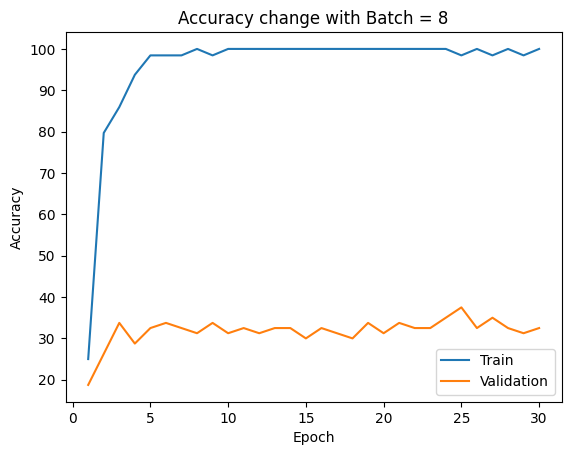

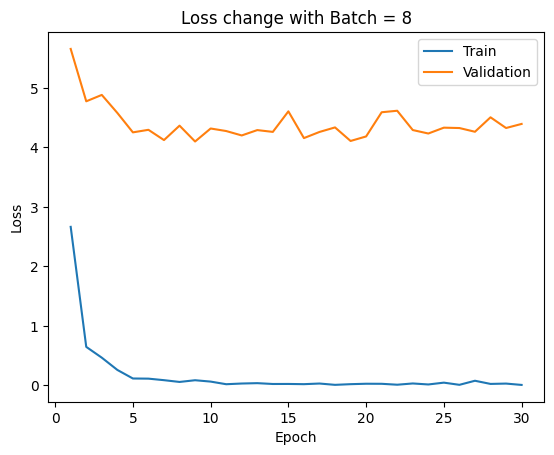

In [ ]:
#PLOT LOSS AND ACCURACY CHANGE OF TRAIN AND VALIDATION SET
def plot(list1,list2,title,name,type):
  plt.plot(range(1,num_epoch+1),list1,  label = "Train")
  plt.plot(range(1,num_epoch+1),list2, label = "Validation")
  plt.xlabel("Epoch")
  plt.ylabel(type)
  plt.title(title)
  plt.legend()
  filename = f"{name}.png"
  plt.savefig(filename)
  plt.show()

plot(train_acc,val_acc,"Accuracy change with Batch = 8","Accuracy_b_8","Accuracy")
plot(train_loss,val_loss,"Loss change with Batch = 8","Loss_b_8","Loss")

###TEST MODEL USING BEST MODEL

In [ ]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()


            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()
            predicted_labels.extend(predicted.tolist())
            true_labels.extend(target.tolist())

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.3f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    # return average loss for the epoch

    return avg_loss, true_labels, predicted_labels

avg_loss, true_labels, predicted_labels = test(best_model, device, testloader)

Validation set: Average loss: 2.253, Accuracy: 21/80 (26.2%)



In [ ]:
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



def confusion(true_labels, predicted_labels):
  cm = confusion_matrix(true_labels, predicted_labels)
  cm_df = pd.DataFrame(cm,
                     index = classes,
                     columns = classes)
  plt.figure(figsize=(5,4))

  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()


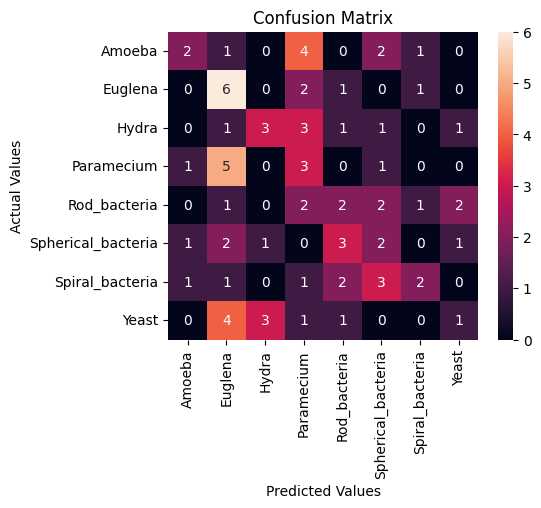

In [ ]:
confusion(true_labels, predicted_labels)

###ADD DROPOUT LAYER

In [30]:
best_model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Flatten(),
    nn.Linear(128 * (img_size//2) * (img_size//2), num_classes)
)

train_drop_loss, train_drop_acc, val_drop_loss, val_drop_acc, best_drop_model = train_val(best_model)

EPOCH:   0
batch 8 loss: 2.16182741522789 acc: 9.375 % 
batch 16 loss: 2.1797971576452255 acc: 12.5 % 
batch 24 loss: 2.1157056838274 acc: 10.9375 % 
batch 32 loss: 2.200006902217865 acc: 7.8125 % 
batch 40 loss: 2.1089364737272263 acc: 17.1875 % 
batch 48 loss: 2.128272831439972 acc: 10.9375 % 
LOSS train 2.128 valid 4.0539997816085815
avg loss  4.0539997816085815
EPOCH:   1
batch 8 loss: 1.9707060009241104 acc: 21.875 % 
batch 16 loss: 1.9526198208332062 acc: 29.6875 % 
batch 24 loss: 1.8615822792053223 acc: 31.25 % 
batch 32 loss: 1.9689617902040482 acc: 25.0 % 
batch 40 loss: 1.9708852618932724 acc: 20.3125 % 
batch 48 loss: 1.872693344950676 acc: 28.125 % 
LOSS train 1.873 valid 4.002888107299805
avg loss  4.002888107299805
EPOCH:   2
batch 8 loss: 1.7589672803878784 acc: 42.1875 % 
batch 16 loss: 1.7982352375984192 acc: 40.625 % 
batch 24 loss: 1.766547754406929 acc: 46.875 % 
batch 32 loss: 1.766625240445137 acc: 43.75 % 
batch 40 loss: 1.7706989347934723 acc: 37.5 % 
batch 48 l

In [31]:
max(val_drop_acc)

36.25

###TEST WITH DROPOUT LAYER

In [32]:
avg_drop_loss, true_drop_labels, predicted_drop_labels = test(best_drop_model, device, testloader)


Validation set: Average loss: 1.885, Accuracy: 22/80 (27.5%)



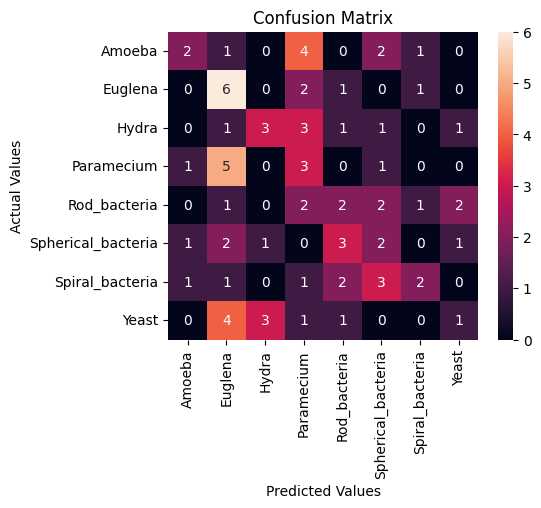

In [33]:
confusion(true_labels, predicted_labels)